In [70]:
import torch
from models.model_search import Network
import pickle
from tools.config import mc_mask_dddict, peak_memory_lookup_key_dddict
import logging
from parsing_model import *

model_path = './checkpoints/search-20220504-172321-TF-NAS-lam0.1-lat15.0-gpu/searched_model_15.pth.tar'

with open('./latency_pkl/peak_memory_cpu.pkl', 'rb') as f:
	peak_memory_lookup = pickle.load(f)

# mc_maxnum_dddict = get_mc_num_dddict(mc_mask_dddict, is_max=True)
# model = Network(200, mc_maxnum_dddict, target_mem = 0.5, memory_lookup = peak_memory_lookup)
# model = torch.nn.DataParallel(model).cuda()
# model.module.set_temperature(5.0)

# parsing model architecture
op_weights, depth_weights, quantized_weights= get_op_and_depth_weights(model_path)
parsed_arch = parse_architecture(op_weights, depth_weights, quantized_weights)
print(parsed_arch)
mc_mask_dddict = torch.load(model_path)['mc_mask_dddict']
mc_num_dddict  = get_mc_num_dddict(mc_mask_dddict)

# model = Network(200, parsed_arch, mc_num_dddict)
# model = torch.nn.DataParallel(model).cuda()

print(quantized_weights)

OrderedDict([('stage1', OrderedDict([('block1', [0, 0])])), ('stage2', OrderedDict([('block1', [1, 1])])), ('stage3', OrderedDict([('block1', [0, 3]), ('block2', [3, 3]), ('block3', [1, 3]), ('block4', [3, 3])])), ('stage4', OrderedDict([('block1', [3, 3])])), ('stage5', OrderedDict([('block1', [1, 3])]))])
[array([0.9855076 , 0.00923025, 0.00355354, 0.00170848], dtype=float32), array([0.23362042, 0.56194884, 0.14848064, 0.05595018], dtype=float32), array([0.19612086, 0.6766947 , 0.0901768 , 0.03700763], dtype=float32), array([0.10424535, 0.12522718, 0.2306568 , 0.5398706 ], dtype=float32), array([0.10741486, 0.12877357, 0.23548885, 0.52832276], dtype=float32), array([0.08780569, 0.10974105, 0.16972682, 0.6327264 ], dtype=float32), array([0.00386799, 0.0028366 , 0.00918229, 0.98411316], dtype=float32), array([0.00391143, 0.00319314, 0.00960693, 0.98328847], dtype=float32), array([0.00354134, 0.00387894, 0.00938572, 0.983194  ], dtype=float32), array([0.00316225, 0.00361332, 0.00879488,

In [71]:
from models.layers import *

PRIMITIVES = [
	'MBI_k3_e3',
	'MBI_k3_e6',
	'MBI_k5_e3',
	'MBI_k5_e6',
	# 'skip',
]

OPS = {
	'MBI_k3_e3' : lambda ic, mc, oc, s, aff, act: MBInvertedResBlock(ic, mc, 0, oc, 3, s, affine=aff, act_func=act),
	'MBI_k3_e6' : lambda ic, mc, oc, s, aff, act: MBInvertedResBlock(ic, mc, 0, oc, 3, s, affine=aff, act_func=act),
	'MBI_k5_e3' : lambda ic, mc, oc, s, aff, act: MBInvertedResBlock(ic, mc, 0, oc, 5, s, affine=aff, act_func=act),
	'MBI_k5_e6' : lambda ic, mc, oc, s, aff, act: MBInvertedResBlock(ic, mc, 0, oc, 5, s, affine=aff, act_func=act),
	# 'skip'      : lambda ic, mc, oc, s, aff, act: IdentityLayer(ic, oc),
}

def get_lookup_peak_memory(parsed_arch, mc_num_dddict, peak_memory_lookup_key_dddict, peak_memory_lookup, stage):
	peak_memory = 0.
	
	for block in parsed_arch[stage]:
		op_idx = parsed_arch[stage][block][0]
		quant_idx = parsed_arch[stage][block][1]
		mid_channels_key = mc_num_dddict[stage][block][op_idx]
		print(mid_channels_key)
		peak_memory_lookup_key = peak_memory_lookup_key_dddict[stage][block][op_idx]
		cur_peak_memory = peak_memory_lookup[peak_memory_lookup_key][mid_channels_key]
		# 0 : 4-bit , 1 : 8-bit, 2 : 16-bit, 3: 32-bit
		cur_peak_memory = cur_peak_memory / (2**(3-quant_idx))
		peak_memory = max(peak_memory, cur_peak_memory)

	return peak_memory

peak_memory = []

for stage in range(1,6):
	peak_mem = get_lookup_peak_memory(parsed_arch, mc_num_dddict, peak_memory_lookup_key_dddict, peak_memory_lookup, 'stage{}'.format(stage))
	peak_memory.append(peak_mem)
	print('stage {} peak memory : {}'.format(stage, peak_mem))

63
stage 1 peak memory : 0.4725341796875
143
stage 2 peak memory : 0.49945068359375
127
508
480
508
stage 3 peak memory : 0.49945068359375
556
stage 4 peak memory : 0.49945068359375
448
stage 5 peak memory : 0.57421875


In [26]:
T_peak_memory = [6.809625,2.583984375, 1.07666015625, 0.562255859375,0.9091796875 ]

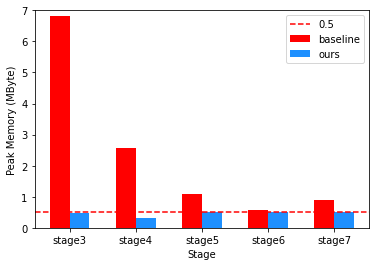

In [69]:
# peak memory graph
import matplotlib.pyplot as plt
import numpy as np

x  = np.arange(5)
stage = ['stage3', 'stage4', 'stage5', 'stage6', 'stage7']
width = 0.3

fig, ax = plt.subplots()
ax.bar(x - width / 2, T_peak_memory, color='red', width = 0.3, label = 'baseline')
ax.bar(x + width / 2, peak_memory,color = 'dodgerblue', width =0.3 , label = 'ours')
plt.xticks(x, stage)
# 그래프 제목
plt.title('')
# 축 이름
plt.xlabel('Stage')
plt.ylabel('Peak Memory (MByte)')
# y 축 범위
plt.ylim([0, 7])
plt.axhline(y=0.5, color='r', linestyle='dashed', label='0.5')
plt.legend()
# 파일로 저장
plt.savefig('experiment_result/peak_memory_tf-nas-q.png', transparent = False)

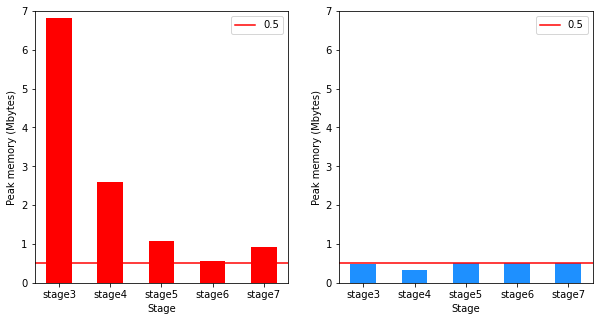

In [54]:
f, axes = plt.subplots(1,2)
f.set_size_inches((10,5))
axes[0].bar(stage, T_peak_memory, color = 'red', width =0.5)
axes[0].axhline(y=0.5, color='r', linestyle='-', label='0.5')
axes[0].set_xlabel('Stage')
axes[0].set_ylabel('Peak memory (Mbytes)')
axes[0].set_ylim([0,7])
axes[0].legend()
axes[1].bar(stage, peak_memory, color = 'dodgerblue', width = 0.5)
axes[1].set_xlabel('Stage')
axes[1].set_ylabel('Peak memory (Mbytes)')
axes[1].axhline(y=0.5, color='r', linestyle='-', label='0.5')
axes[1].set_ylim([0,7])
axes[1].legend()

plt.savefig('experiment_result/peak_memory_tf-nas-q.png', transparent = False)

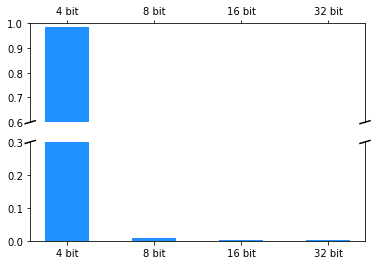

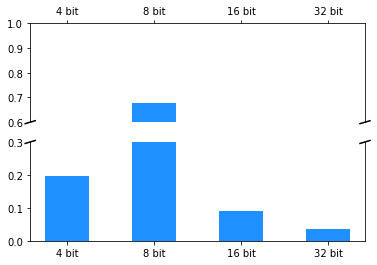

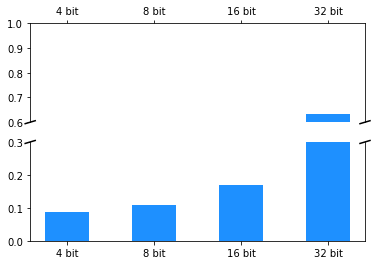

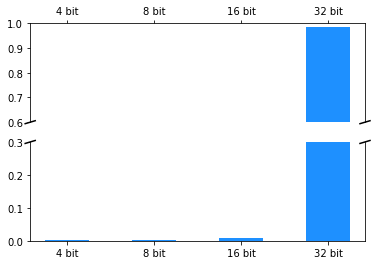

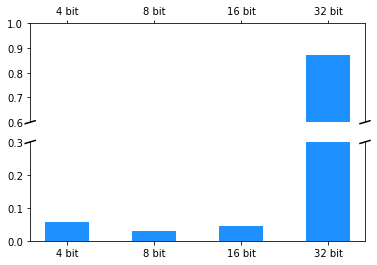

In [36]:
# g weights 그리기
stage_blk1_gweights = []
stage1_1_g_weights = quantized_weights[0]
stage_blk1_gweights.append(quantized_weights[0])
stage2_1_g_weights = quantized_weights[2]
stage_blk1_gweights.append(quantized_weights[2])
stage3_1_g_weights = quantized_weights[5]
stage_blk1_gweights.append(quantized_weights[5])
stage4_1_g_weights = quantized_weights[9]
stage_blk1_gweights.append(quantized_weights[9])
stage5_1_g_weights = quantized_weights[13]
stage_blk1_gweights.append(quantized_weights[13])

x_2  = np.arange(4)
quantization = ['4 bit', '8 bit', '16 bit', '32 bit']

for i in range(5):
    gweights = stage_blk1_gweights[i]
    # plt.bar(x_2, gweights, color='dodgerblue', width=0.5)
    # plt.xticks(x_2, quantization)
    # 그래프 제목
    # plt.title('stage {}'.format(i+1))
    # # 축 이름
    # plt.xlabel('Quantization Precision')
    # plt.ylabel('Gamma Value')

    f,(ax,ax2) = plt.subplots(2,1,sharex=True)

    # plot the same data on both axes
    ax.bar(quantization, gweights, color='dodgerblue', width=0.5)
    ax2.bar(quantization, gweights, color='dodgerblue', width=0.5)

    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(.6,1) # outliers only
    ax2.set_ylim(0,.3) # most of the data

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop='off') # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
    ax.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
    ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal

    plt.show()